# Experiment Notebook 
#### This notebook is meant to experiment with different parameters, architectures, and normalization methods associated with the gRNA2knockdown Library.
#### The basic characteristic of the model as developed by Enoch Yeung are still preserved in the __main__ function of the module.

In [13]:
import os
import csv
import numpy as np
import platereadertools as prt
import gRNA2knockdown as g2k 

import matplotlib.pyplot as plt 
import tensorflow as tf

#### First Let's import or data, the description of which is below:
- The sequencing data is imported as a CSV and contains gRNA designs which tile the target (GFP) with 3bp of overlap.
- The time series data is imported as a TSV text file generated BioTek's Gen5 software and from data collected on Synergy H1s.
- The experimental design is:
  - Total run time = 18 hours
  - Time step = 3 min.
  - Reads:
    - OD600: Absorbance at 600 nm
    - Fluorescence: Excitation = 480 nm, Emission = 510 nm.
  - Runs where conducted with breath-easy film to reduce moisture loss.

In [7]:
# First we need to load the data
data_fp = "Data/"
spacer_fp = os.path.join(data_fp, "GFP_spacers.gbk")
data_0nM_fp = os.path.join(data_fp,
                            "p2x11_80memberlibrary_0mMIPTG20230730.txt")
data_10mM_fp = os.path.join(data_fp,
                            "p2x11_80memberlib_10mMIPTG20230730.txt")

# Organize the label, sequence data from platereadertools and the csv standard module.
seqs = csv.reader(open("Data/GFP_spacers.csv"))
allseqs = [seq for seq in seqs]
data0, time0 = prt.Organize(data_0nM_fp, 8, 12, 18, 3/60)
data1, time1 = prt.Organize(data_10mM_fp, 8, 12, 18, 3/60)

# Based off of the timeseries data, we can see that the greatest change in flourescence occurs at timepoint 165 
# (~8hours). We will use this timepoint to calculate the fold change between the 0mM and 10mM data.
reads = list(data0.keys())
data_pt0 = data0[reads[1]][:,:,165]
data_pt1 = data1[reads[1]][:,:,165]

# Calculate the fold change between the 0mM and 10mM data.
fold_change = data_pt1/data_pt0
data = np.reshape(fold_change,(96))

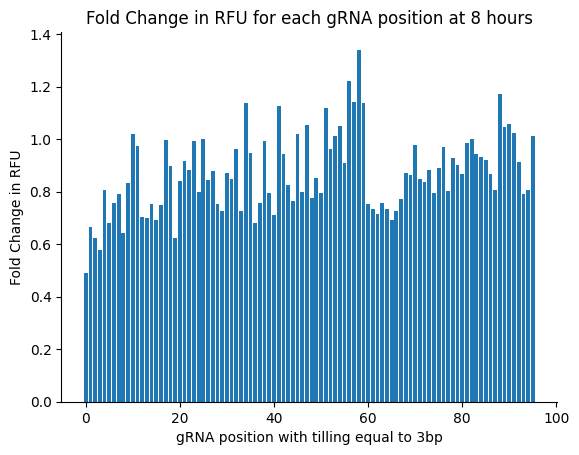

In [8]:
fig, ax = plt.subplots(1,1)
ax.bar(range(len(data)), data)
ax.set_xlabel("gRNA position with tilling equal to 3bp")
ax.set_ylabel('Fold Change in RFU')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Fold Change in RFU for each gRNA position at 8 hours")
if True:
    plt.savefig("./Figures/foldchange.png")

### Define the gRNA2knockdown model parameters.
- The size of the gRNAs is 30 bp, so it makes may make sense to make the intermediate layers 30 nodes.
- For now lets keep the embedding space the same size, and not try to use the resnet functionality.

In [9]:
stride_parameter = 2
label_dim = 1
embedding_dim = 18
intermediate_dim = 30
batch_size_parameter=300 #4000 for howard's e. coli dataset (from Enoch's code)
debug_splash = 0
this_step_size_val = 0.25
this_corpus, this_labels = g2k.make_labeled_corpus(allseqs, data, stride_parameter)

In [10]:
# Define the random transformation householder matrix.
Rand_Transform = g2k.rvs(dim=stride_parameter)

# Define the corpus for the model.
this_corpus_vec = []
for this_corpus_elem in this_corpus:
    vec_value = g2k.sequence_encoding(this_corpus_elem)
    vec_value = np.dot(Rand_Transform,vec_value)

    this_corpus_vec.append(vec_value)

this_corpus_vec = np.asarray(this_corpus_vec)
this_labels = np.expand_dims(this_labels,axis=1)
print(len(this_labels))
hidden_vars_list = [embedding_dim, stride_parameter]

2784


### Build the model.

In [14]:
# Define the tensorflow session
sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution() # needed because of placeholder variables

this_u = tf.compat.v1.placeholder(tf.float32, 
                                    shape=[None,stride_parameter])

with tf.device('/cpu:0'):
    this_W_list,this_b_list = g2k.initialize_Wblist(sess, stride_parameter,
                                                hidden_vars_list)
    this_y_out,all_layers = g2k.network_assemble(sess, this_u,this_W_list,this_b_list
                                            ,keep_prob=1.0,
                                            activation_flag=2,res_net=0)

this_embedding = all_layers[-2]
regress_list = [intermediate_dim]*1+[label_dim]
with tf.device('/cpu:0'):
    this_Wregress_list,this_bregress_list = g2k.initialize_Wblist(embedding_dim,
                                                                regress_list)

    HybridLoss = g2k.customLoss(this_y_out,this_u,this_embedding)
    result = sess.run(tf.compat.v1.global_variables_initializer())
    this_optim = tf.compat.v1.train.AdagradOptimizer(
        learning_rate=this_step_size_val).minimize(HybridLoss)
    step_size = tf.compat.v1.placeholder(tf.float32,shape=[])
    result = sess.run(tf.compat.v1.global_variables_initializer())
    this_vae_loss = g2k.vae_loss(this_y_out,this_u)
    this_embed_loss = g2k.embed_loss(this_u,this_embedding)

TypeError: initialize_Wblist() takes 2 positional arguments but 3 were given